# Detecting breast cancer metastases  

The challenge proposed is a weakly-supervised binary classification problem : predict whether a patient **has any metastase** in its lymph node or not, given its slide.  

My approach was the following : 
- Use the annotated patients to create a model that would predict if a **tile** has any metastase. *(Input : Tile. — Output : Probability of metastase in tile.)*
- Make predictions on every tile of each non-annotated patient and create a model that would predict if a **patient** has any metastase. *(Input : Predictions on all the tiles. — Output : Probability of metastase in patient.)*

I originally wanted to apply this method on the images directly but I ran into some complications and so I applied it on the ResNet features instead. You can still find my attempt using the images on the other notebook.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-&amp;-Data-loading" data-toc-modified-id="Import-&amp;-Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import &amp; Data loading</a></span></li><li><span><a href="#Averaging-ResNet-Features" data-toc-modified-id="Averaging-ResNet-Features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Averaging ResNet Features</a></span><ul class="toc-item"><li><span><a href="#Baseline-(Logistic-Regression)" data-toc-modified-id="Baseline-(Logistic-Regression)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Baseline (Logistic Regression)</a></span></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#Feature-importances-using-RF-model" data-toc-modified-id="Feature-importances-using-RF-model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Feature importances using RF model</a></span></li></ul></li><li><span><a href="#Using-Tiles" data-toc-modified-id="Using-Tiles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using Tiles</a></span><ul class="toc-item"><li><span><a href="#Loading-train-tiles-data" data-toc-modified-id="Loading-train-tiles-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Loading train tiles data</a></span></li><li><span><a href="#Model-to-predict-on-tiles" data-toc-modified-id="Model-to-predict-on-tiles-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model to predict on tiles</a></span><ul class="toc-item"><li><span><a href="#Cross-validation-on-the-data" data-toc-modified-id="Cross-validation-on-the-data-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Cross-validation on the data</a></span></li><li><span><a href="#Train-a-model-on-the-full-data" data-toc-modified-id="Train-a-model-on-the-full-data-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Train a model on the full data</a></span></li><li><span><a href="#Feature-importances-on-a-RF-model" data-toc-modified-id="Feature-importances-on-a-RF-model-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Feature importances on a RF model</a></span></li></ul></li><li><span><a href="#New-model-based-on-tiles-predictions." data-toc-modified-id="New-model-based-on-tiles-predictions.-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>New model based on tiles predictions.</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Feature-engineering" data-toc-modified-id="Feature-engineering-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Feature engineering</a></span></li><li><span><a href="#Bit-of-visualization" data-toc-modified-id="Bit-of-visualization-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Bit of visualization</a></span></li><li><span><a href="#Standardization" data-toc-modified-id="Standardization-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Standardization</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Cross-validation-on-the-data" data-toc-modified-id="Cross-validation-on-the-data-3.3.5.1"><span class="toc-item-num">3.3.5.1&nbsp;&nbsp;</span>Cross-validation on the data</a></span></li><li><span><a href="#Train-on-full-data" data-toc-modified-id="Train-on-full-data-3.3.5.2"><span class="toc-item-num">3.3.5.2&nbsp;&nbsp;</span>Train on full data</a></span></li><li><span><a href="#Feature-importance-on-a-RF-model" data-toc-modified-id="Feature-importance-on-a-RF-model-3.3.5.3"><span class="toc-item-num">3.3.5.3&nbsp;&nbsp;</span>Feature importance on a RF model</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-3.3.5.4"><span class="toc-item-num">3.3.5.4&nbsp;&nbsp;</span>Visualization</a></span></li></ul></li><li><span><a href="#Apply-on-test-set" data-toc-modified-id="Apply-on-test-set-3.3.6"><span class="toc-item-num">3.3.6&nbsp;&nbsp;</span>Apply on test set</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Results</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusion</a></span><ul class="toc-item"><li><span><a href="#Improvements" data-toc-modified-id="Improvements-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Improvements</a></span></li></ul></li></ul></div>

## Import & Data loading

In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [2]:
train_directory = "data/train_input/"
test_directory = "data/test_input/"
res_directory = "data/train_input/resnet_features/"

In [3]:
annot = pd.read_csv(train_directory + 'train_tile_annotations.csv')
annot.columns = ['Info', 'Target']
print("Shape : ", annot.shape)
annot.head()

Shape :  (10124, 2)


,Info,Target
0,ID_387_annotated_tile_0_15_69_30.jpg,0.0
1,ID_387_annotated_tile_1_15_23_53.jpg,0.0
2,ID_387_annotated_tile_2_15_58_20.jpg,0.0
3,ID_387_annotated_tile_3_15_67_12.jpg,0.0
4,ID_387_annotated_tile_4_15_57_20.jpg,0.0


In [4]:
annot.Target.value_counts()

0.0    9417
1.0     707
Name: Target, dtype: int64

In [5]:
train_output = pd.read_csv(train_directory + 'training_output.csv')
print("Shape : ", train_output.shape)
train_output.head()

Shape :  (279, 2)


,ID,Target
0,1,0
1,2,0
2,3,0
3,5,0
4,6,0


In [6]:
train_output.Target.value_counts()

0    167
1    112
Name: Target, dtype: int64

## Averaging ResNet Features  

The first thing I wanted to try was to reproduce the reasoning behind the baseline model, which is to average the ResNet features. I wanted to see the results using other models.

In [7]:
def get_average_features(filenames):
    """Load and aggregate the resnet features by the average.

    Args:
        filenames: list of filenames of length `num_patients` corresponding to resnet features

    Returns:
        features: np.array of mean resnet features, shape `(num_patients, 2048)`
    """
    # Load numpy arrays
    features = []
    for f in filenames:
        patient_features = np.load(res_directory + f)

        # Remove location features (but we could use them?)
        patient_features = patient_features[:, 3:]

        aggregated_features = np.mean(patient_features, axis=0)
        features.append(aggregated_features)

    features = np.stack(features, axis=0)
    return features

In [8]:
# Just making sure the IDs are sorted in the output dataframe
train_output['ID'].is_monotonic

True

In [9]:
filenames = [file for file in os.listdir(res_directory)]
features_train = get_average_features(filenames)

In [10]:
labels_train = np.array(train_output.Target)

### Baseline (Logistic Regression)

In [11]:
aucs = []
for seed in range(42,43):
    # Use logistic regression with L2 penalty
    estimator = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear")

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(estimator, X=features_train, y=labels_train,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.7155126010159724, std 0.0693559306375653


In [12]:
aucs

array([[0.63368984, 0.6644385 , 0.7483531 , 0.83135705, 0.69972452]])

### XGBoost

In [13]:
aucs = []
for seed in range(42,43):
    estimator = xgb.XGBClassifier()

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    auc = sklearn.model_selection.cross_val_score(estimator, X=features_train, y=labels_train,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.6885241628092128, std 0.0840255206402196


In [14]:
aucs

array([[0.57486631, 0.75935829, 0.6969697 , 0.79710145, 0.61432507]])

### Feature importances using RF model

In [15]:
aucs = []
for seed in range(42,43):
    estimator = RandomForestClassifier()

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    auc = sklearn.model_selection.cross_val_score(estimator, X=features_train, y=labels_train,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.6800492133612338, std 0.05865537059745238


In [16]:
aucs

array([[0.65173797, 0.60160428, 0.73583663, 0.75955204, 0.65151515]])

In [17]:
forest = RandomForestClassifier()
forest.fit(features_train, labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

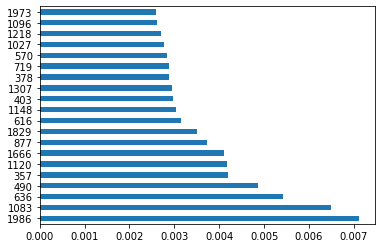

In [18]:
feat_importances = pd.Series(forest.feature_importances_)
feat_importances.nlargest(20).plot(kind='barh')

We approximately get the same results using other classifiers.

## Using Tiles

Instead of averaging the ResNet features, I thought of using the annotated patients to make predictions much more accurate. Since we have 11 000 tiles annotated, we can definitely make use of them to make predictions on tiles themselves (instead of predicting on the average features of those tiles). 

The idea is the following : 

- Build a model on the 11 annotated patients to predict if a **tile** contains a metastase. We'll call it **_tile_classifier_**.
- Load the other 268 patients.
- For each patient, make predictions on each tile using **_tile_classifier_**. Each patient is then characterized by an array of ~ 1000 predictions (or less since some patients have less tiles).
- Build a model, based on the predictions, to predict if a **patient** has any metastase in its lymph node or not.
- Use **_tile_classifier_** on the test set and then use the second model on those predictions.  

For both models I will use a simple Logistic Regression, just like the baseline model. My objective wasn't to find the "best" model with the "best" paramaters, but to make better use of the data available.

### Loading train tiles data

_Note : I chose to keep and make use of the tiles coordinates._

In [19]:
annot['ID'] = annot.Info.str[0:6]
annot['X_coord'] =  annot.Info.str.split('_').str[6]
annot['Y_coord'] = annot.Info.str.split('_').str[7].str[:-4]

annot['X_coord'] = annot['X_coord'].astype(float)
annot['Y_coord'] = annot['Y_coord'].astype(float)

In [20]:
annot.head()

,Info,Target,ID,X_coord,Y_coord
0,ID_387_annotated_tile_0_15_69_30.jpg,0.0,ID_387,69.0,30.0
1,ID_387_annotated_tile_1_15_23_53.jpg,0.0,ID_387,23.0,53.0
2,ID_387_annotated_tile_2_15_58_20.jpg,0.0,ID_387,58.0,20.0
3,ID_387_annotated_tile_3_15_67_12.jpg,0.0,ID_387,67.0,12.0
4,ID_387_annotated_tile_4_15_57_20.jpg,0.0,ID_387,57.0,20.0


In [21]:
def load_tiles(IDs):
    data = []
    for ID in IDs:
        patient = np.load(res_directory + ID + '_annotated.npy')
        patient = patient[:, 1:]
        data.append(patient)
    data = np.concatenate(data, axis=0)
    data = pd.DataFrame(data)
    data.rename(columns={0: "Coord_x", 1: "Coord_y"}, inplace=True)
    return data

In [22]:
# I'm using the order of the IDs in the annotation.csv to load each patient. (Patients in annotations.csv are not sorted by ID)
ID_order = list(annot.ID.unique())
tiles_features = load_tiles(ID_order)
print(tiles_features.shape)
tiles_features.head()

(10124, 2050)


,Coord_x,Coord_y,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049
0,69.0,30.0,1.414122,0.676988,0.000000,0.003139,0.006868,0.107312,0.110727,0.0,...,0.076402,0.000000,0.000000,0.016007,0.168164,0.0,0.000000,5.042528,1.282534,0.041764
1,23.0,53.0,0.444906,1.801952,0.211628,0.043701,0.161008,0.837296,0.030582,0.0,...,0.105955,0.356565,0.000000,0.083840,0.175326,0.0,0.009897,1.371318,0.583364,0.000860
2,58.0,20.0,1.063327,0.003382,0.599520,0.000000,0.000000,0.255530,0.007793,0.0,...,0.120413,0.014894,0.000000,0.033674,0.000000,0.0,0.013897,0.021275,0.000000,0.000000
3,67.0,12.0,0.349135,0.000000,0.325726,0.000000,0.181404,0.006151,0.000000,0.0,...,0.151650,0.000000,0.021141,0.055808,0.000000,0.0,0.000000,0.261275,0.000000,0.023108
4,57.0,20.0,0.454522,0.000000,0.016670,0.000000,0.384957,0.151944,0.000000,0.0,...,0.005902,0.000000,0.000000,0.004038,0.000000,0.0,0.000000,0.265646,0.000000,0.043415


In [23]:
tiles_features = pd.concat([tiles_features, annot[['Target', 'X_coord', 'Y_coord']]], axis=1)
print(tiles_features.shape)
tiles_features.head()

(10124, 2053)


,Coord_x,Coord_y,2,3,4,5,6,7,8,9,...,2043,2044,2045,2046,2047,2048,2049,Target,X_coord,Y_coord
0,69.0,30.0,1.414122,0.676988,0.000000,0.003139,0.006868,0.107312,0.110727,0.0,...,0.016007,0.168164,0.0,0.000000,5.042528,1.282534,0.041764,0.0,69.0,30.0
1,23.0,53.0,0.444906,1.801952,0.211628,0.043701,0.161008,0.837296,0.030582,0.0,...,0.083840,0.175326,0.0,0.009897,1.371318,0.583364,0.000860,0.0,23.0,53.0
2,58.0,20.0,1.063327,0.003382,0.599520,0.000000,0.000000,0.255530,0.007793,0.0,...,0.033674,0.000000,0.0,0.013897,0.021275,0.000000,0.000000,0.0,58.0,20.0
3,67.0,12.0,0.349135,0.000000,0.325726,0.000000,0.181404,0.006151,0.000000,0.0,...,0.055808,0.000000,0.0,0.000000,0.261275,0.000000,0.023108,0.0,67.0,12.0
4,57.0,20.0,0.454522,0.000000,0.016670,0.000000,0.384957,0.151944,0.000000,0.0,...,0.004038,0.000000,0.0,0.000000,0.265646,0.000000,0.043415,0.0,57.0,20.0


Since I also extracted X & Y from the name of the file, I can compare them to the ones in annotation.csv to make sure I assign the correct Target value to each tile.

In [24]:
# Checking just to make sure the target values are attributed to the correct tiles.
print(tiles_features['Coord_x'].equals(tiles_features['X_coord']))
print(tiles_features['Coord_y'].equals(tiles_features['Y_coord']))

True
True


In [25]:
tiles_labels = np.array(tiles_features.Target)
tiles_features.drop(['X_coord', 'Y_coord', 'Target'], axis=1, inplace=True)

In [26]:
# Standardization of the coordinates. Their values are much higher than Resnet features so this allows to scale them correctly.
coord_mean = tiles_features[['Coord_x', 'Coord_y']].mean()
coord_std = tiles_features[['Coord_x', 'Coord_y']].std()

tiles_features[['Coord_x', 'Coord_y']] = (tiles_features[['Coord_x', 'Coord_y']] - coord_mean) / coord_std

### Model to predict on tiles

#### Cross-validation on the data

In [27]:
aucs = []
for seed in range(42,43):
    # Use logistic regression with L2 penalty
    estimator = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear")

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(estimator, X=tiles_features, y=tiles_labels,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.9492994459569808, std 0.012604627416197573


In [28]:
aucs

array([[0.93218367, 0.95618572, 0.93605125, 0.96224185, 0.95983473]])

We get a pretty high AUC even though the classes are imbalanced. This is very positive since our whole approach revolves around classifying tiles. If that classifier isn't reliable, then our second model, which works on the predictions of the classifier, will not give good results.

#### Train a model on the full data

In [29]:
estimator = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear")
estimator.fit(tiles_features, tiles_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

When I went through the course [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science), one of the lesson was about ensembling methods. One thing that caught my mind was the instructor mentioned that when he would participate in competitions, he would usually make submissions using a bagging version of a certain model, not just one model.  
That's why I wanted to try it out here and see if it would improve our predictions.

In [30]:
from sklearn.ensemble import BaggingClassifier
tiles_classifier = BaggingClassifier(base_estimator=sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear"),n_estimators=10, random_state=42)
tiles_classifier.fit(tiles_features, tiles_labels)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=4

#### Feature importances on a RF model

I was pretty curious whether or not the coordinates were important in making a prediction so I just wanted to see if they would appear as important features in a random forest model. 

In [31]:
rf = RandomForestClassifier()
rf.fit(tiles_features, tiles_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

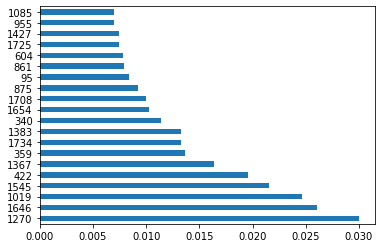

In [32]:
feat_importances = pd.Series(rf.feature_importances_, index=tiles_features.columns)
feat_importances.nlargest(20).plot(kind='barh')

### New model based on tiles predictions.  

Now comes the second part of our idea : building a model based on the predictions of the rest of the patients.  

#### Data

In [33]:
files = [file for file in os.listdir(res_directory) if 'annotated' not in file]

In [34]:
def load_res(files, directory):
    data = pd.DataFrame(columns = ['ID', 'Predictions'])
    rows = []
    for file in files:
        patient = np.load(directory + file)
        patient = pd.DataFrame(patient[:, 1:])
        patient.rename(columns={0: "Coord_x", 1: "Coord_y"}, inplace=True)
        patient[['Coord_x', 'Coord_y']] = (patient[['Coord_x', 'Coord_y']] - coord_mean) / coord_std
        
        # Using the simple logistic regression
        # preds = tiles_classifier.predict_proba(patient)[:, 1]
        
        # Using the bagging classifier
        preds = tiles_classifier.predict_proba(patient)[:, 1]
        rows.append({'ID':int(file[3:6]), 'Predictions':preds})
        
    data = pd.DataFrame(rows, columns = ['ID', 'Predictions'])              
    return data

In [35]:
res_train_features = load_res(files, res_directory)
print(res_train_features.shape)
res_train_features.head()

(268, 2)


,ID,Predictions
0,1,"[1.1542013879410283e-05, 0.0008490391208253141..."
1,2,"[0.00021115420494274107, 8.440413912976636e-06..."
2,3,"[0.00040197625633553864, 0.0006589001758326207..."
3,5,"[4.5044872513669925e-06, 0.0001168596073935127..."
4,6,"[0.0007404804769013441, 0.10709544010430105, 8..."


In [36]:
# Again, making sure the IDs are the same before assigning the target values.
(train_output[train_output['ID'].isin(res_train_features['ID'].values)].ID.values == res_train_features.ID.values).all()

True

In [37]:
res_train_features['Target'] = train_output[train_output['ID'].isin(res_train_features['ID'].values)].Target.values

In [38]:
res_train_features.head()

,ID,Predictions,Target
0,1,"[1.1542013879410283e-05, 0.0008490391208253141...",0
1,2,"[0.00021115420494274107, 8.440413912976636e-06...",0
2,3,"[0.00040197625633553864, 0.0006589001758326207...",0
3,5,"[4.5044872513669925e-06, 0.0001168596073935127...",0
4,6,"[0.0007404804769013441, 0.10709544010430105, 8...",0


#### Feature engineering

Since all patients don't have the same number of tiles (at most 1000 but some have less), I couldn't simply feed the predictions to a neural network. What I did was to extract useful informations from each set of predictions and build a model based on those newly generated features.  

Here are the features I generated :

- Number of predictions with a probability > 0.1, > 0.2, > 0.3 ... > 0.9.
- Mean of predictions with a probability > 0.1, > 0.2, > 0.3 ... > 0.9.
- Value of the highest probability.
- Since we can consider elements with a probability > 0.5 as Positives (this could be tuned), I also checked the number of **positive elements that had a positive neighbor**. I felt like if a tile had some metastase, maybe the ones next to it also have some metastase. But it might be a little bit flawed since we're not dealing with a closeness in depth. What I mean by that is that tiles are not like a brain MRI where if some tumor is present at a certain depth, then some tumor will very likely be present in the neighbouring layers. But in this case tiles are fragments of a large image of huge size, so one tile maybe in the top right corner of that image and the next tile is actually a little bit lower but at the left of that image (so not close at all). Anyway, it was just to clarify that this feature might not be 100% accurate and we would need a better understanding of the tiles distribution to accurately generate it.  

These are the features I thought might be interesting but I'm sure other features could be found (for example ratios instead of number of elements, top n predictions etc...).

In [39]:
res_train_features_copy = res_train_features.copy()

In [40]:
# This will allow us to count the number of positive elements who have a positive neighbor.
# I'm using np.where to find the indexes of positive elements, which is what will be the input of that function.
def count_neighbor(array):
    """ 
    Count the number of elements that satisfy this condition:
            array[i+1] = array[i] + 1
        or
            array[i-1] = array[i] - 1
    """
    count = 0
    length = len(array)
    
    if(length > 1):
        
        for i in range(len(array)):
            
            if i == 0:
                if array[i + 1] == array[i] + 1:
                    count+=1
                
            elif i == len(array) - 1:
                if array[i - 1] == array[i] - 1:
                    count+=1
                
            else:
                if (array[i - 1] == array[i] - 1) or (array[i + 1] == array[i] + 1):
                    count+=1
                
    return count

In [41]:
res_train_features_copy['Positives'] = res_train_features_copy['Predictions'].apply((lambda x: len(np.where(x > 0.5)[0])))
res_train_features_copy['Count_Positive_Neighbors'] = res_train_features_copy['Predictions'].apply((lambda x: count_neighbor(np.where(x > 0.5)[0])))
res_train_features_copy['max'] = res_train_features_copy['Predictions'].apply((lambda x: np.amax(x)))

In [42]:
for i in np.arange(0.1, 1, 0.1):
    p = round(i,2)
    res_train_features_copy['Count_' + str(p)] = res_train_features_copy['Predictions'].apply((lambda x: len(np.where(x > p)[0])))
    res_train_features_copy['Mean_' + str(p)] = res_train_features_copy['Predictions'].apply((lambda x: np.mean(x[x > p])))

C:\Users\ilyag\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [43]:
res_train_features_copy.isnull().sum(axis = 0)

ID                            0
Predictions                   0
Target                        0
Positives                     0
Count_Positive_Neighbors      0
max                           0
Count_0.1                     0
Mean_0.1                      1
Count_0.2                     0
Mean_0.2                      8
Count_0.3                     0
Mean_0.3                     20
Count_0.4                     0
Mean_0.4                     37
Count_0.5                     0
Mean_0.5                     53
Count_0.6                     0
Mean_0.6                     84
Count_0.7                     0
Mean_0.7                    110
Count_0.8                     0
Mean_0.8                    152
Count_0.9                     0
Mean_0.9                    181
dtype: int64

In [44]:
res_train_features_copy.fillna(0.0, inplace = True)

In [45]:
res_train_features_copy.head()

,ID,Predictions,Target,Positives,Count_Positive_Neighbors,max,Count_0.1,Mean_0.1,Count_0.2,Mean_0.2,...,Count_0.5,Mean_0.5,Count_0.6,Mean_0.6,Count_0.7,Mean_0.7,Count_0.8,Mean_0.8,Count_0.9,Mean_0.9
0,1,"[1.1542013879410283e-05, 0.0008490391208253141...",0,1,0,0.720606,24,0.220620,9,0.365560,...,1,0.720606,1,0.720606,1,0.720606,0,0.000000,0,0.000000
1,2,"[0.00021115420494274107, 8.440413912976636e-06...",0,1,0,0.735163,47,0.218858,22,0.311126,...,1,0.735163,1,0.735163,1,0.735163,0,0.000000,0,0.000000
2,3,"[0.00040197625633553864, 0.0006589001758326207...",0,12,0,0.844674,97,0.274403,52,0.387546,...,12,0.646944,7,0.723482,5,0.758383,1,0.844674,0,0.000000
3,5,"[4.5044872513669925e-06, 0.0001168596073935127...",0,1,0,0.594628,31,0.206928,12,0.315861,...,1,0.594628,0,0.000000,0,0.000000,0,0.000000,0,0.000000
4,6,"[0.0007404804769013441, 0.10709544010430105, 8...",0,16,0,0.921811,112,0.280092,58,0.403671,...,16,0.644447,10,0.704941,3,0.817631,2,0.863925,1,0.921811


#### Bit of visualization

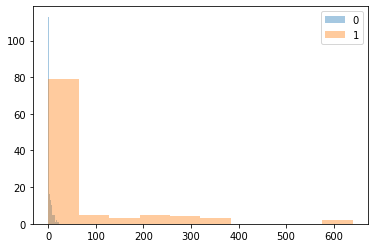

In [46]:
res_train_features_copy.groupby("Target").Positives.hist(alpha=0.4, grid=False)
plt.legend(['0', '1'])
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000222C37FE648>,
      dtype=object)

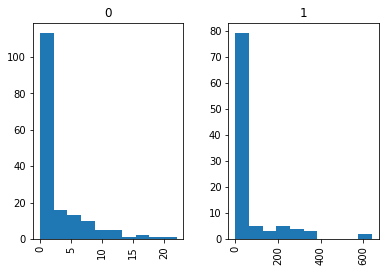

In [47]:
res_train_features_copy['Positives'].hist(by=res_train_features_copy['Target'], )

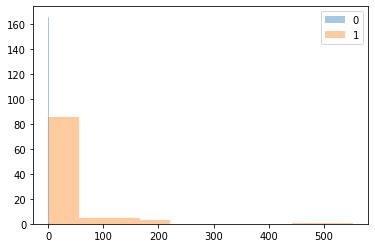

In [48]:
res_train_features_copy.groupby("Target").Count_Positive_Neighbors.hist(alpha=0.4, grid=False)
plt.legend(['0', '1'])
plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000222C3824908>,
      dtype=object)

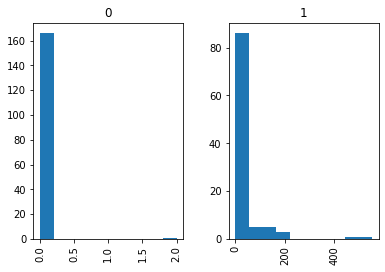

In [49]:
res_train_features_copy['Count_Positive_Neighbors'].hist(by=res_train_features_copy['Target'], )

What is interesting (but you cannot see here) is that when using the simple **tile_classifier** (not the bagging version of it) the class 0 had much more Positives and Count_Positive_Neighbor. The bagging version is thus much more reliable when predicting positive classes.

#### Standardization

In [50]:
res_train_labels = res_train_features_copy['Target'].values
### Positives is the same as Count_O5 that's why we also drop it as a feature.
features = list(res_train_features_copy.drop(['Target', 'Positives', 'Predictions', 'ID'], axis=1).columns)

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
res_train_features_scaled = scaler.fit_transform(res_train_features_copy[features])

#### Model

##### Cross-validation on the data

In [52]:
aucs = []
for seed in range(40,46):
    # Use logistic regression with L2 penalty
    model = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear")

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(model, X=res_train_features_scaled, y=res_train_labels,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.873644922615511, std 0.04854665608456823


In [53]:
# Random Forest
aucs = []
for seed in range(40,46):
    # Use logistic regression with L2 penalty
    model = sklearn.ensemble.RandomForestClassifier()

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(model, X=res_train_features_scaled, y=res_train_labels,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.8590161064425771, std 0.044573460673602384


In [54]:
# XGBoost
aucs = []
for seed in range(40,46):
    # Use logistic regression with L2 penalty
    model = xgb.XGBClassifier(max_depth=8)

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(model, X=res_train_features_scaled, y=res_train_labels,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.8427351950881362, std 0.04247356208171113


In [55]:
# SVM
from sklearn.svm import SVC
aucs = []
for seed in range(40,46):
    model = SVC()

    cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True,
                                                 random_state=seed)

    # Cross validation on the training set
    auc = sklearn.model_selection.cross_val_score(model, X=res_train_features_scaled, y=res_train_labels,
                                                  cv=cv, scoring="roc_auc", verbose=0)

    aucs.append(auc)

aucs = np.array(aucs)

print("Predicting weak labels by mean resnet")
print("AUC: mean {}, std {}".format(aucs.mean(), aucs.std()))

Predicting weak labels by mean resnet
AUC: mean 0.8609707014118779, std 0.05392381990557014


##### Train on full data

In [56]:
final_model = sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear")
final_model.fit(res_train_features_scaled, res_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Using a bagging version of that classifier to improves our results.

In [57]:
patient_classifier = BaggingClassifier(base_estimator=sklearn.linear_model.LogisticRegression(penalty="l2", C=1.0, solver="liblinear"),n_estimators=10, random_state=42)
patient_classifier.fit(res_train_features_scaled, res_train_labels)

BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='liblinear',
                                                    tol=0.0001, verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=4

##### Feature importance on a RF model

In [58]:
rf_2 = RandomForestClassifier()
rf_2.fit(res_train_features_scaled, res_train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

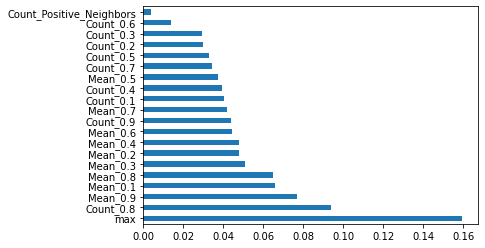

In [59]:
feat_importances = pd.Series(rf_2.feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

##### Visualization

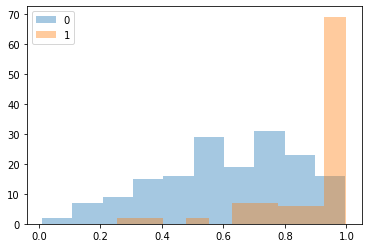

In [60]:
res_train_features_copy.groupby("Target")['max'].hist(alpha=0.4, grid=False)
plt.legend(['0', '1'])
plt.show()

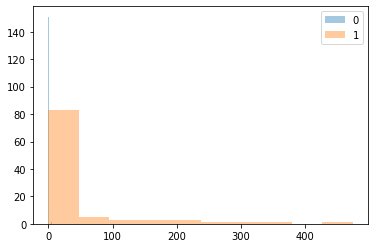

In [61]:
res_train_features_copy.groupby("Target")['Count_0.9'].hist(alpha=0.4, grid=False)
plt.legend(['0', '1'])
plt.show()

Another thing that is very intersting is that the simple tile classifier had actually much more prediction where the maximum value among the predictions was above 0.9 for the target 0 (around 60~70 instead of here ~15). The bagging version thus is more reliable when making predictions > 0.9.

#### Apply on test set

In [62]:
test_res_directory = "data/test_input/resnet_features/"
files_test = [file for file in os.listdir(test_res_directory) if 'annotated' not in file]
res_test = load_res(files_test, test_res_directory)

In [63]:
# Adding features
res_test['Positives'] = res_test['Predictions'].apply((lambda x: len(np.where(x > 0.5)[0])))
res_test['Count_Positive_Neighbors'] = res_test['Predictions'].apply((lambda x: count_neighbor(np.where(x > 0.5)[0])))
res_test['max'] = res_test['Predictions'].apply((lambda x: np.amax(x)))

for i in np.arange(0.1, 1, 0.1):
    p = round(i,2)
    res_test['Count_' + str(p)] = res_test['Predictions'].apply((lambda x: len(np.where(x > p)[0])))
    res_test['Mean_' + str(p)] = res_test['Predictions'].apply((lambda x: np.mean(x[x > p])))

# Filling NAs
res_test.fillna(0.0, inplace = True)

# Scaling
res_test_scaled = scaler.transform(res_test[features])

C:\Users\ilyag\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [64]:
# To use non-bagging version.
# preds_test = final_model.predict_proba(res_test_scaled)[:,1]

preds_test = patient_classifier.predict_proba(res_test_scaled)[:,1]

test_output = pd.DataFrame()
test_output['ID'] = res_test['ID']
test_output['Target'] = preds_test
test_output.set_index("ID", inplace=True)
test_output.to_csv('submissions/preds_test.csv')

In [65]:
test_output.head()

,Target
ID,
0,0.207998
4,0.209908
16,0.881522
17,0.999386
20,0.244337


### Results

Tiles_classifier -> Simple Logistic Regression  
Second model -> Simple Logistic Regression  
Result on test set : **0.7338** AUC

Tiles_classifier -> Bagging of Logistic Regression  
Second model -> Simple Logistic Regression  
Result on test set : **0.8194** AUC

Tiles_classifier -> Bagging of Logistic Regression  
Second model -> Bagging of Logistic Regression  
Result on test set : **0.8206** AUC

## Conclusion

Through this study we managed to predict whether a patient has any metastase in its lymph node or not based on the tiles of histopathology slides. Using simple logistic regression models allowed us to achieve **0.8206** AUC (using ensembling methods) but a lot of improvement can still be made.

### Improvements

As I said earlier my objective was to try to build a method that would make use of the annotated patients, so improvements can be made in testing other classifiers and tuning hyperparameters.  

Other ideas I wanted to try:
- Fix my attempt at a CNN so that we can apply the same method but directly on images.
- Use a neural network directly on the probabilities (i.e. finding a way to have the same input for all patients despite the difference in number of tiles). This would allow the network to directly train on "raw" data and thus will prevent loss of information that comes from generating features.
- Find other ways to use the probabilities (create new features, or using only the n top predictions etc..)